In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
# get images
impath = "images"
batch_size = 32
im_size = (256, 256)

# generate the training set
train_set = image_dataset_from_directory(
    impath,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=batch_size,
    image_size=im_size,
)

# generate the validation set
val_set = image_dataset_from_directory(
    impath,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=batch_size,
    image_size=im_size,
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


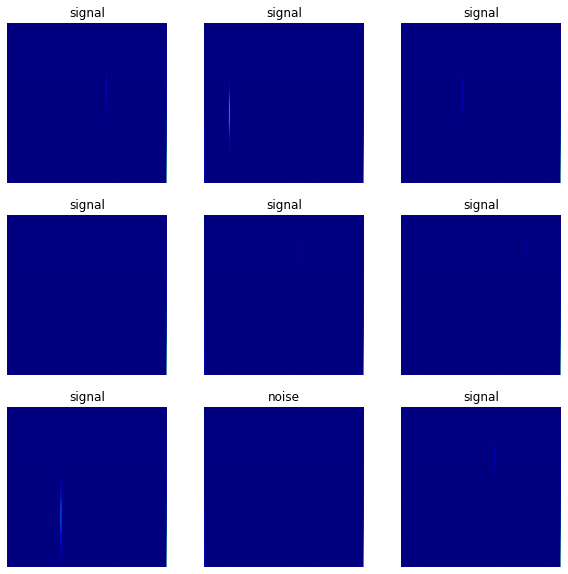

In [32]:
class_names = train_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
plt.savefig("train-data.svg")

In [4]:
# generate a test set 
test_batches = tf.data.experimental.cardinality(train_set)
test_set = train_set.take(test_batches // 10)
train_set = train_set.skip(test_batches // 10)
print("Number of validation batches: %d" % tf.data.experimental.cardinality(val_set))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_set))

Number of validation batches: 13
Number of test batches: 5


In [5]:
# tweak I/O
autotune = tf.data.experimental.AUTOTUNE
train_set = train_set.prefetch(buffer_size=autotune)
val_set = val_set.prefetch(buffer_size=autotune)
test_set = test_set.prefetch(buffer_size=autotune)

In [6]:
# load model without top layer, allowing us to train our own classes
im_size = im_size + (3,)
base_model = InceptionV3(include_top=False, input_shape=im_size)

In [7]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
# freeze base model weight
base_model.trainable = False

# create new layers
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [8]:
# build modified model
inputs = tf.keras.Input(shape=im_size)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_avg_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
# compile our model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [11]:
# evaluate the model before training
loss0, accuracy0 = model.evaluate(val_set)

13/13 [==============================] - 16s 969ms/step - loss: 0.6678 - accuracy: 0.5312


In [12]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.67
initial accuracy: 0.51


In [13]:
# fit the model
epochs = 100
es = EarlyStopping()
history = model.fit(train_set, epochs=epochs, validation_data=val_set, callbacks=[es])

Epoch 1/100
45/45 [==============================] - 68s 1s/step - loss: 0.6232 - accuracy: 0.5611 - val_loss: 0.5668 - val_accuracy: 0.6850
Epoch 2/100
45/45 [==============================] - 64s 1s/step - loss: 0.5419 - accuracy: 0.7111 - val_loss: 0.4965 - val_accuracy: 0.7750
Epoch 3/100
45/45 [==============================] - 65s 1s/step - loss: 0.4821 - accuracy: 0.7708 - val_loss: 0.4477 - val_accuracy: 0.8100
Epoch 4/100
45/45 [==============================] - 64s 1s/step - loss: 0.4395 - accuracy: 0.8000 - val_loss: 0.4124 - val_accuracy: 0.8200
Epoch 5/100
45/45 [==============================] - 65s 1s/step - loss: 0.4109 - accuracy: 0.8208 - val_loss: 0.3856 - val_accuracy: 0.8375
Epoch 6/100
45/45 [==============================] - 64s 1s/step - loss: 0.3870 - accuracy: 0.8222 - val_loss: 0.3644 - val_accuracy: 0.8425
Epoch 7/100
45/45 [==============================] - 63s 1s/step - loss: 0.3649 - accuracy: 0.8326 - val_loss: 0.3463 - val_accuracy: 0.8475
Epoch 8/100
4

In [14]:
model.save("ligo_scaleogram_model")

INFO:tensorflow:Assets written to: ligo_scaleogram_model/assets


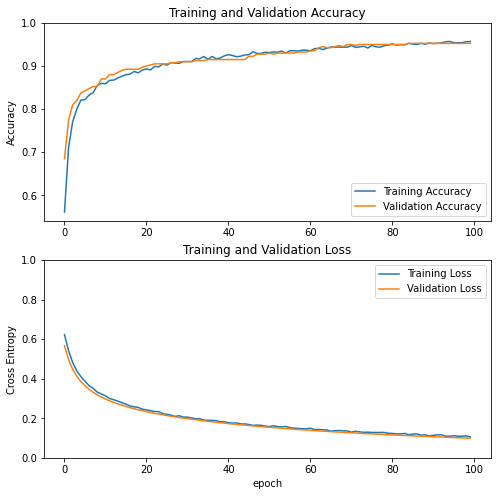

In [34]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.savefig("100-epochs-stats.svg")

In [17]:
loss, accuracy = model.evaluate(test_set)
print("Test accuracy :", accuracy)

5/5 [==============================] - 7s 990ms/step - loss: 0.0725 - accuracy: 0.9812
Test accuracy : 0.981249988079071


Predictions:
 [0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0]
Labels:
 [0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0]


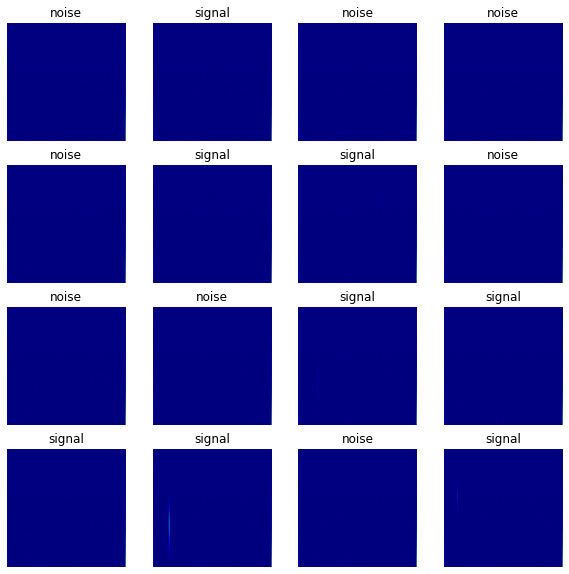

In [28]:
image_batch, label_batch = test_set.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

plt.savefig("predict-labels.svg")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])